In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import descartes
from shapely.geometry import Point, Polygon

%matplotlib inline

In [2]:
def fix_crs(map_ob):
    return map_ob.to_crs({'init': 'epsg:4326'})

def df_to_geodf(df):
    return gpd.GeoDataFrame(df, crs = {'init': 'epsg:4326'})

UBC_poly = [(-123.26494, 49.26512), (-123.26308, 49.25894), (-123.25409, 49.25118), (-123.22587, 49.23889), (-123.19758, 49.23532),(-123.1979, 49.24501), (-123.2054, 49.24898),(-123.20218, 49.25358),(-123.20382, 49.25832),(-123.21564, 49.25873),(-123.21564, 49.26374),(-123.22793, 49.26326),(-123.22896, 49.26656),(-123.22264, 49.26889),(-123.2269, 49.27322),(-123.22662, 49.27947),(-123.24743, 49.2805),(-123.26267, 49.27047),(-123.26494, 49.26512)]

min_long = 100
min_lat = 100

for val in UBC_poly:
    if (val[0] < min_long):
        min_long = val[0]
    if (val[1] < min_lat):
        min_lat = val[1]
        
max_long = -200
max_lat = -200

for val in UBC_poly:
    if (val[0] > max_long):
        max_long = val[0]
    if (val[1] > max_lat):
        max_lat = val[1]

In [3]:
van = gpd.read_file("Boundaries - Census Divisions 2011/CD_2011.shp")
van = fix_crs(van)

In [4]:
df_UBC = pd.read_csv("Gbif_UBC.csv", delimiter="\t", low_memory=False)

# Fix precision for lat, long to 6 decimal places
df_UBC.decimalLatitude = df_UBC.decimalLatitude.round(6)
df_UBC.decimalLongitude = df_UBC.decimalLongitude.round(6)

# Prune taxonRank != "SPECIES"
df_UBC = df_UBC[df_UBC['taxonRank'] == "SPECIES"]

# Append geometry column to UBC dataframe
geometry = [Point(xy) for xy in zip (df_UBC['decimalLongitude'], df_UBC['decimalLatitude'])]
df_UBC['geometry'] = geometry


<h3> Plot all species on UBC </h3>

In [5]:

# geo_df = gpd.GeoDataFrame(df_UBC, geometry = geometry, crs = {'init': 'epsg:4326'})

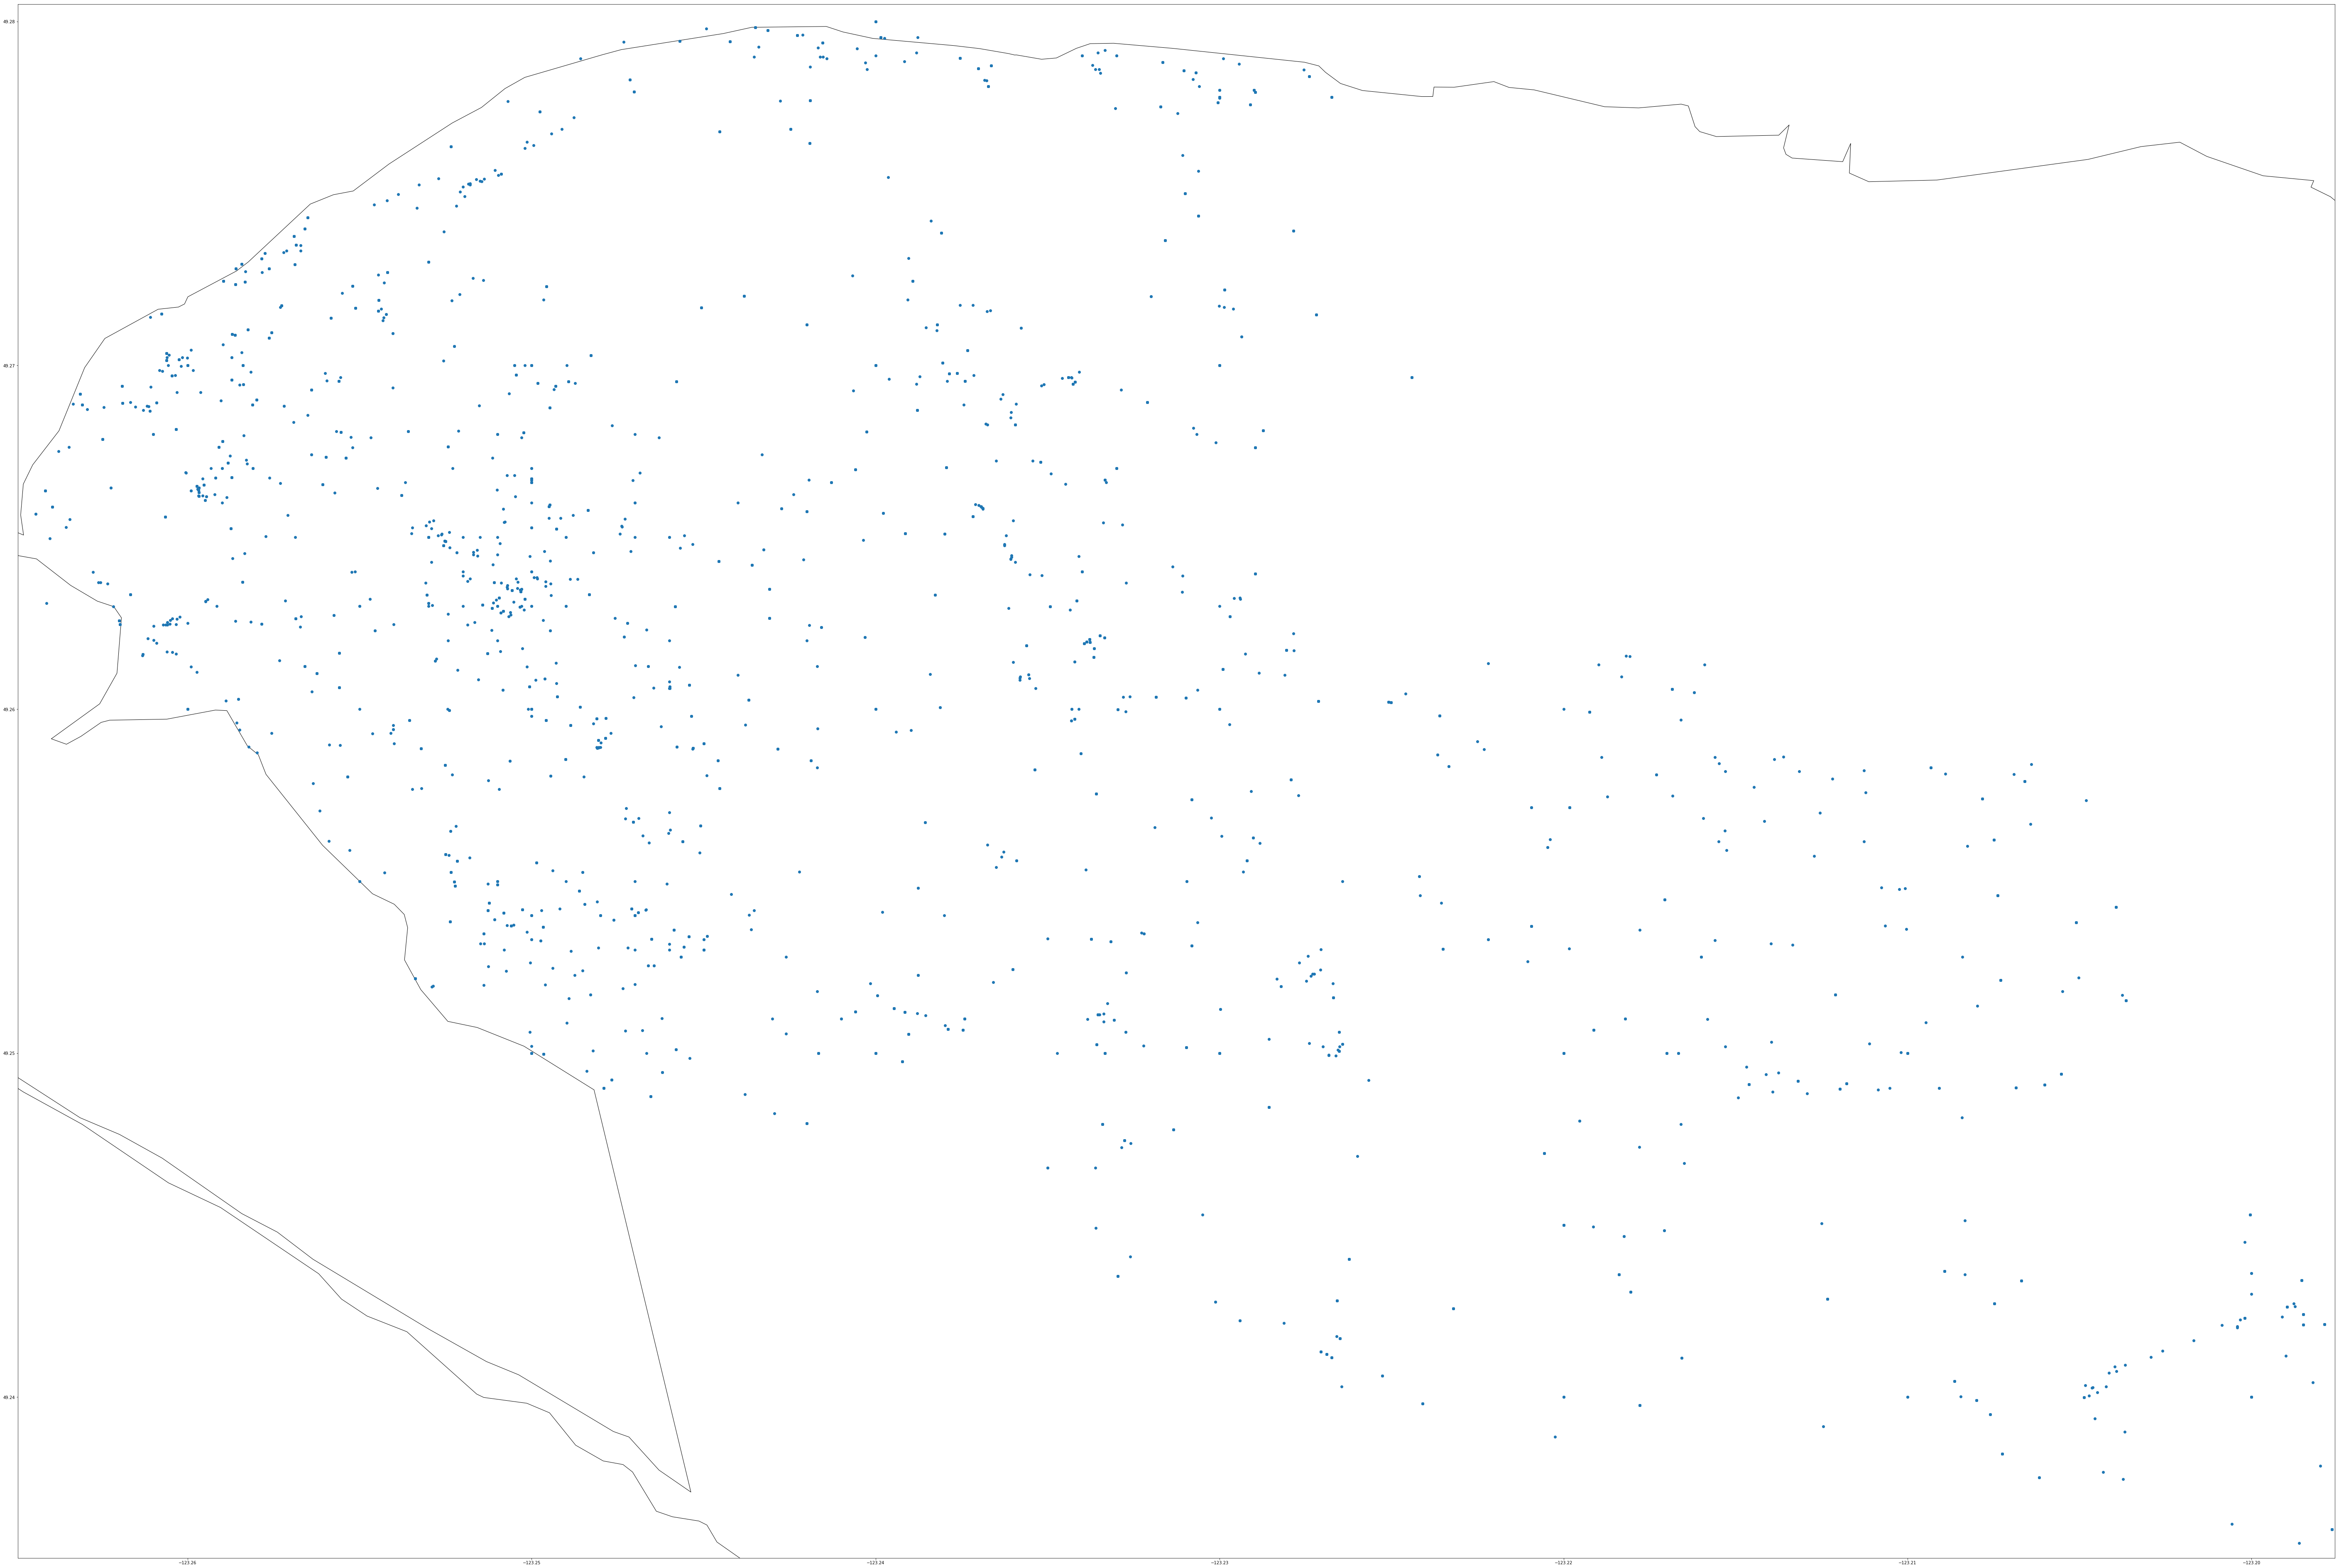

In [6]:
fig, ax = plt.subplots(figsize = (100,100))
ax.set_ylim(min_lat, max_lat)
ax.set_xlim(min_long, max_long)
# TODO: Make the boundries darker
van.plot(ax = ax, color='white', edgecolor='black',)
df_to_geodf(df_UBC).plot(ax = ax)

<h3> Digging deeper </h3>

<h4> 81794 Examples </h4>

* Every example has Lat, Long, scientificName
* 6512 groups based on scientificName
* 5 examples don't have kingdom
* 10 examples don't have phylum
* 12 examples don't have class
* 12 examples don't have order
* 32 examples don't have family
* 91 examples don't have genus
* 2062 examples don't have species

<h3> Red Lists </h3>

In [7]:
df_red = pd.read_csv("redlist_assessments.csv")

# Assume: RedList scientific correspond to UBC species
red_sciNames = df_red.scientificName

In [8]:
df_UBC_red = df_UBC[df_UBC['species'].isin(red_sciNames)]

In [9]:
UBC_red_groups = df_UBC_red.groupby('species').size().sort_values(ascending=False)
UBC_red_groups

species
Selasphorus rufus           630
Podiceps auritus            400
Hesperiphona vespertina     179
Cypseloides niger           123
Contopus cooperi             80
Brachyramphus marmoratus     67
Clangula hyemalis            66
Tsuga canadensis             10
Taxus brevifolia              5
Sequoia sempervirens          4
Fraxinus americana            4
Chamaecyparis lawsoniana      4
Fraxinus nigra                3
Calidris pusilla              3
Fraxinus pennsylvanica        2
Ilex collina                  2
Galanthus nivalis             2
Pinus coulteri                2
Cupressus bakeri              2
Coreopsis rosea               1
Bombus occidentalis           1
Tsuga caroliniana             1
Cupressus macrocarpa          1
Fraxinus latifolia            1
Fraxinus quadrangulata        1
Lupinus rivularis             1
Picea breweriana              1
Somateria mollissima          1
Abies fraseri                 1
dtype: int64

In [10]:
df_UBC_red_top = df_UBC_red[df_UBC_red['species'] == UBC_red_groups.index[0]]

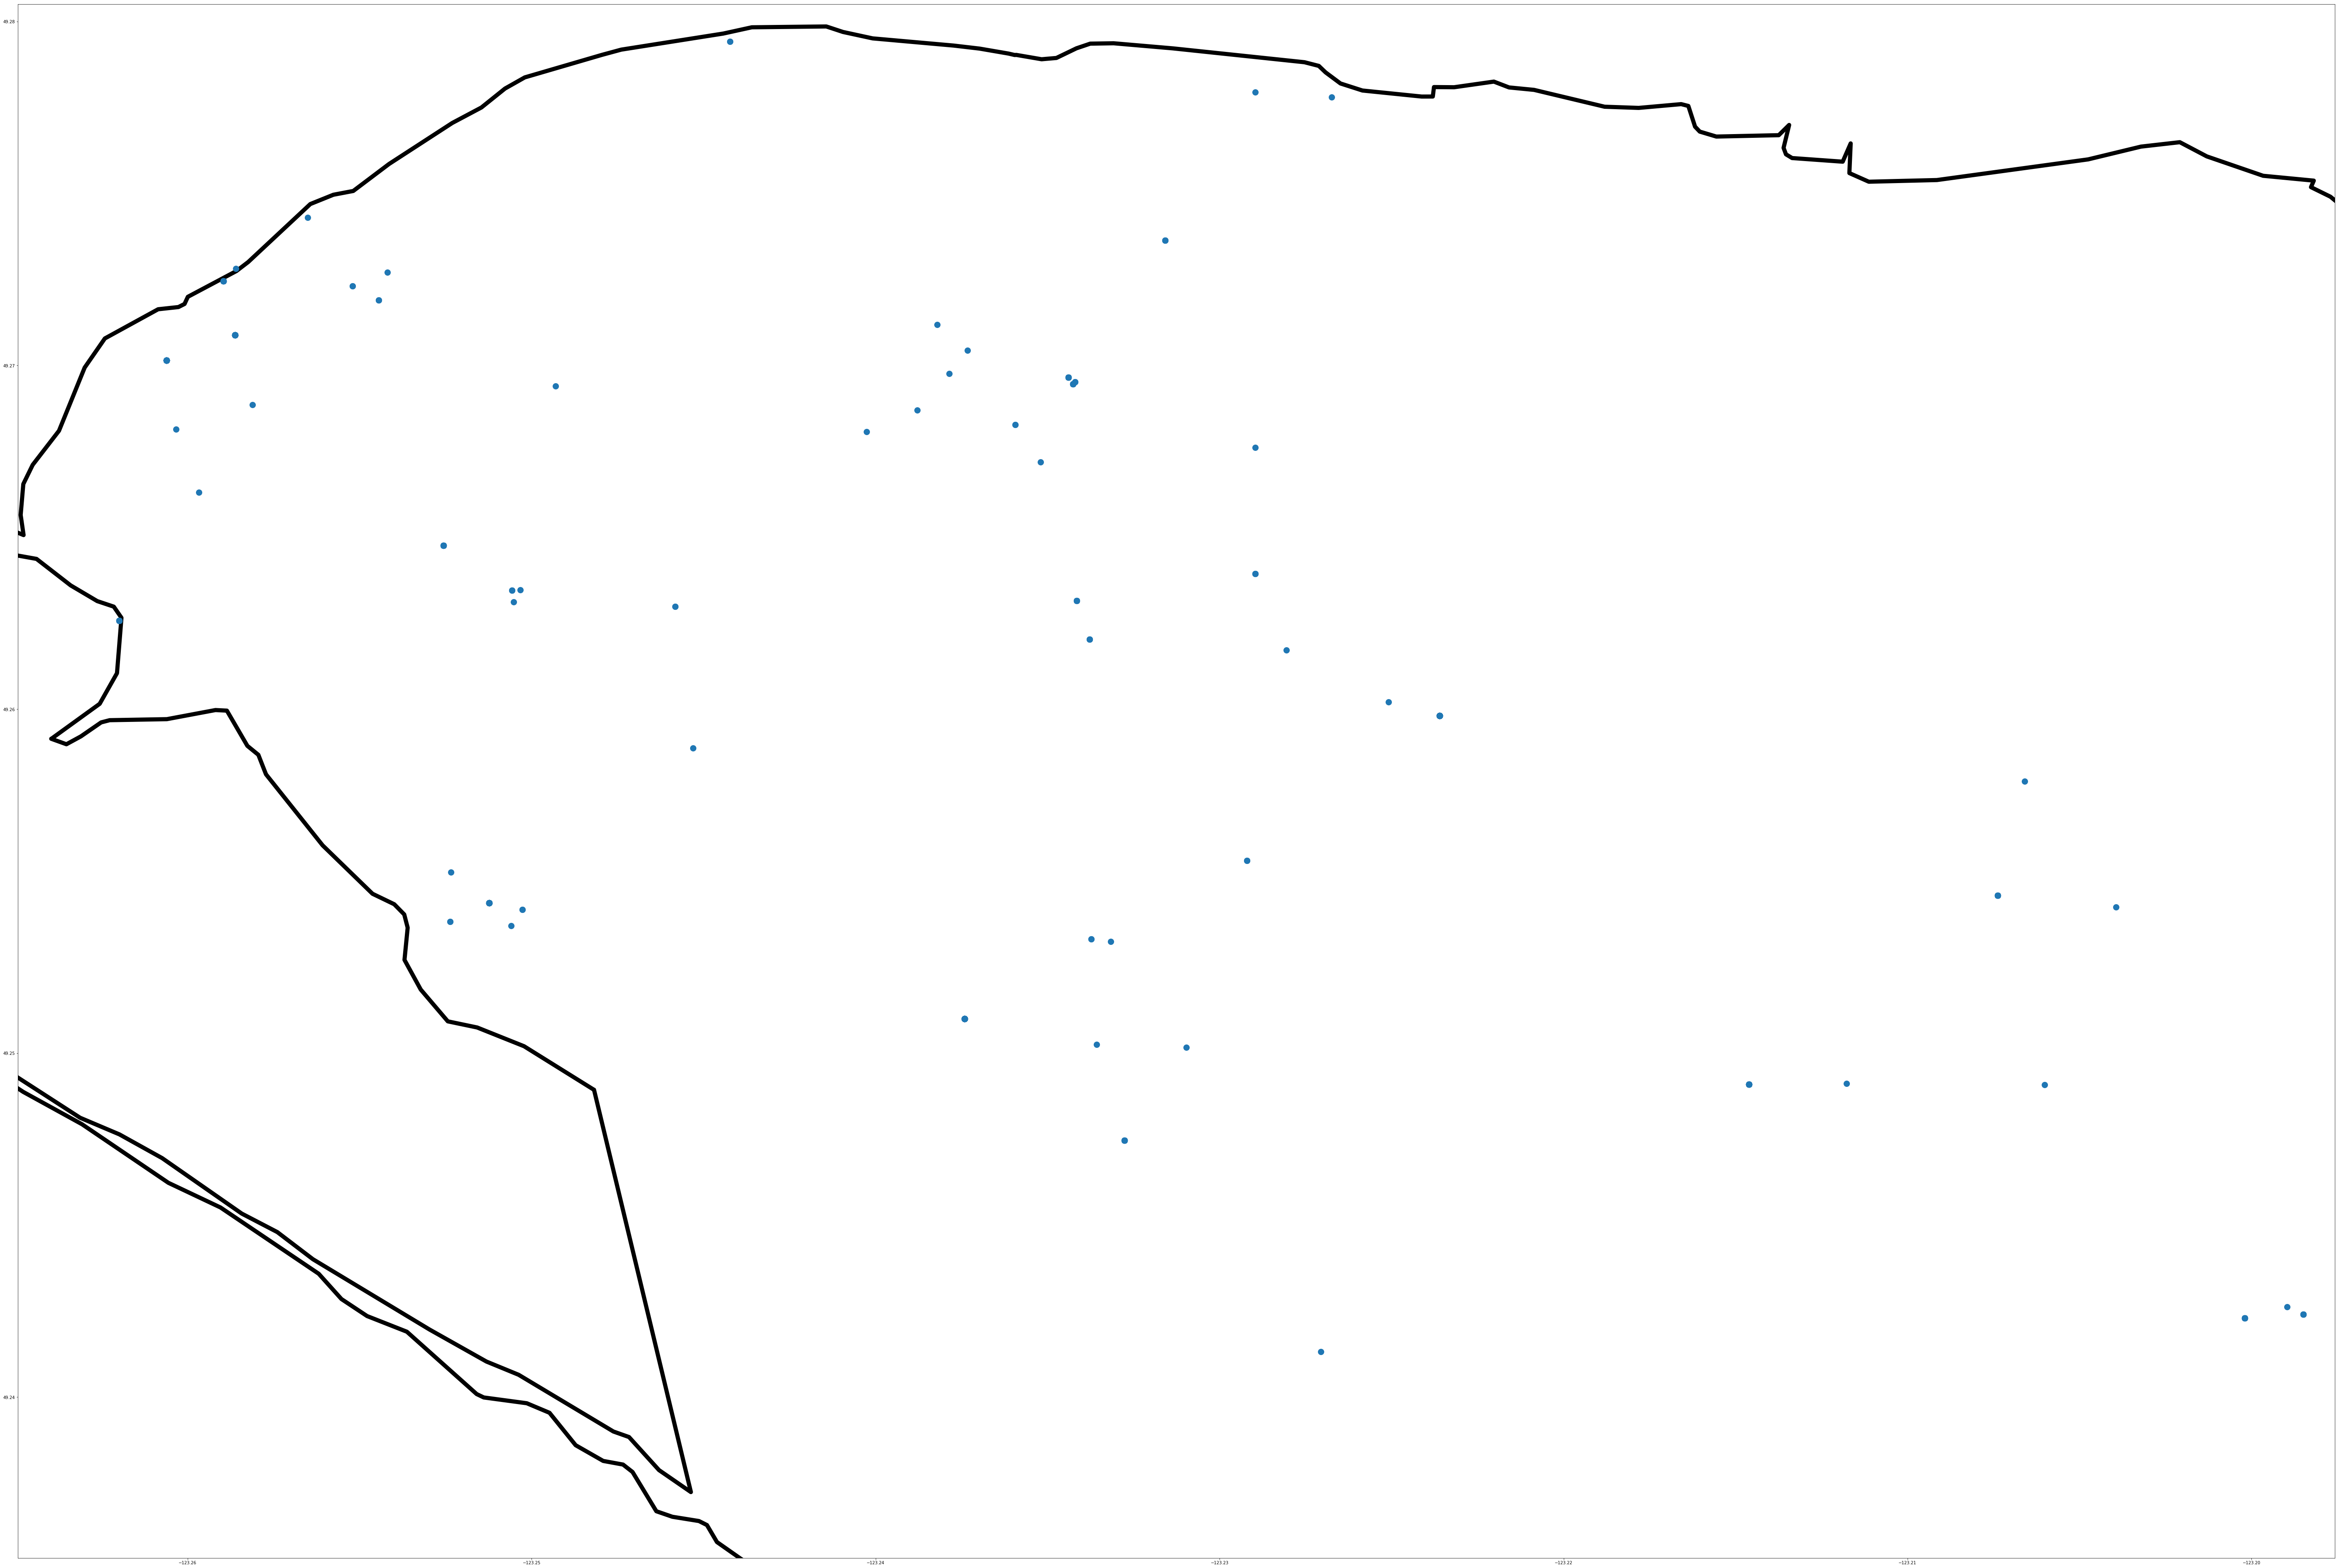

In [11]:
fig, ax = plt.subplots(figsize = (100,100))
ax.set_ylim(min_lat, max_lat)
ax.set_xlim(min_long, max_long)
# TODO: Make the boundries darker
van.plot(ax = ax, color='white', edgecolor='black', linewidth = 10)
df_to_geodf(df_UBC_red_top).plot(ax = ax, markersize = 200)

In [12]:
# Check for overlapping coordinates
pos_groups = df_UBC_red_top.groupby(['decimalLatitude', 'decimalLongitude'])
max_occuring_coords = pos_groups.size().sort_values(ascending=False)
max_occuring_coords

decimalLatitude  decimalLongitude
49.270140        -123.260620         101
49.251000        -123.237419          98
49.259812        -123.223601          83
49.270883        -123.258620          64
49.254361        -123.251238          56
49.249088        -123.214610          32
49.272453        -123.258963          24
49.264760        -123.252570          16
49.242300        -123.200200          14
49.262570        -123.261990          13
49.247456        -123.232763          12
49.254585        -123.207378          12
49.269653        -123.234399          11
49.269457        -123.234265          10
49.263156        -123.234158           7
49.242400        -123.198500           6
49.273629        -123.231583           5
49.262029        -123.233779           4
49.263940        -123.228965           4
49.269513        -123.234200           3
49.271891        -123.254446           3
49.255600        -123.229200           3
49.263456        -123.250567           3
49.254168        -123.2

In [14]:
max_occuring_coord = max_occuring_coords.index[0]

In [15]:

# df_pruned = df_UBC_red_top[df_UBC_red_top.apply(lambda x: 
#                                     x['geometry'].coords[0][0] >= min_long and x['geometry'].coords[0][0] <= max_long
#                                     and x['geometry'].coords[0][1] >= min_lat and x['geometry'].coords[0][1] <= max_lat, axis = 1)]


In [17]:
df_repeat = df_UBC_red_top[(df_UBC_red_top['decimalLatitude'] == max_occuring_coord[0]) & (df_UBC_red_top['decimalLongitude'] == max_occuring_coord[1])]


In [18]:
df_repeat.locality.unique()

array(['UBC--Cecil Green & Museum of Anthropology grounds'], dtype=object)

In [19]:
df_repeat.groupby('year').size().sort_values(ascending=False)

year
2015.0    24
2014.0    20
2017.0     9
2007.0     9
2012.0     7
2018.0     6
2013.0     5
2008.0     4
2016.0     3
2005.0     3
2001.0     3
2011.0     2
1999.0     2
2006.0     1
2002.0     1
2000.0     1
1987.0     1
dtype: int64

In [20]:
df_repeat.iloc[0]

gbifID                                                                  2197115114
datasetKey                                    4fa7b334-ce0d-4e88-aaae-2e0c138d049e
occurrenceID                                    URN:catalog:CLO:EBIRD:OBS651546529
kingdom                                                                   Animalia
phylum                                                                    Chordata
class                                                                         Aves
order                                                                  Apodiformes
family                                                                 Trochilidae
genus                                                                  Selasphorus
species                                                          Selasphorus rufus
infraspecificEpithet                                                           NaN
taxonRank                                                                  SPECIES
scie